In [8]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [34]:
import tensorflow.keras.utils as np_utils
from tensorflow.keras.utils import plot_model

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import cv2

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Reshape, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [14]:
path = '/content/drive/MyDrive/ck+'

In [15]:
# total number of images in the dataset

count_dict = {}
total = 0

for dir_ in os.listdir(path):
  count = 0
  for f in os.listdir(path+"/"+dir_+"/"):
    count+=1
  total += count
  count_dict[dir_] = count

for x,y in count_dict.items():
  print(f"\n {x} has {y} images.")

print(f"\n \n There are {total} images in total.")


 anger has 135 images.

 disgust has 177 images.

 happy has 207 images.

 fear has 75 images.

 surprise has 249 images.

 sadness has 84 images.

 contempt has 54 images.

 
 There are 981 images in total.


In [24]:
img_arr = np.empty(shape=(total, *(48,48,1)))
img_label = np.empty(shape=(total))
label_to_text = {}

i=0
label = 0

for dir_ in os.listdir(path):
  label_to_text[label] = dir_
  for f in os.listdir(path+ "/" + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(path +"/"+ dir_ + "/" + f, 0), axis=2)
            img_label[i] = label
            i += 1

  print(f"loaded {dir_} images to numpy arrays...")
  label += 1

img_label = np_utils.to_categorical(img_label)
print(f"\nShapes of img_arr and img_label : {img_arr.shape} , {img_label.shape}")


loaded anger images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...
loaded fear images to numpy arrays...
loaded surprise images to numpy arrays...
loaded sadness images to numpy arrays...
loaded contempt images to numpy arrays...

Shapes of img_arr and img_label : (981, 48, 48, 1) , (981, 7)


In [25]:
label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'happy',
 3: 'fear',
 4: 'surprise',
 5: 'sadness',
 6: 'contempt'}

In [27]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'anger': 0,
 'disgust': 1,
 'happy': 2,
 'fear': 3,
 'surprise': 4,
 'sadness': 5,
 'contempt': 6}

In [30]:
img_arr = img_arr / 255.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.7, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((686, 48, 48, 1), (295, 48, 48, 1), (686, 7), (295, 7))

In [32]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), activation='relu',input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Reshape((1,-1)))

model.add(LSTM(64))

model.add(Dense(1028,activation='relu'))
model.add(Dense(7,activation='softmax'))


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

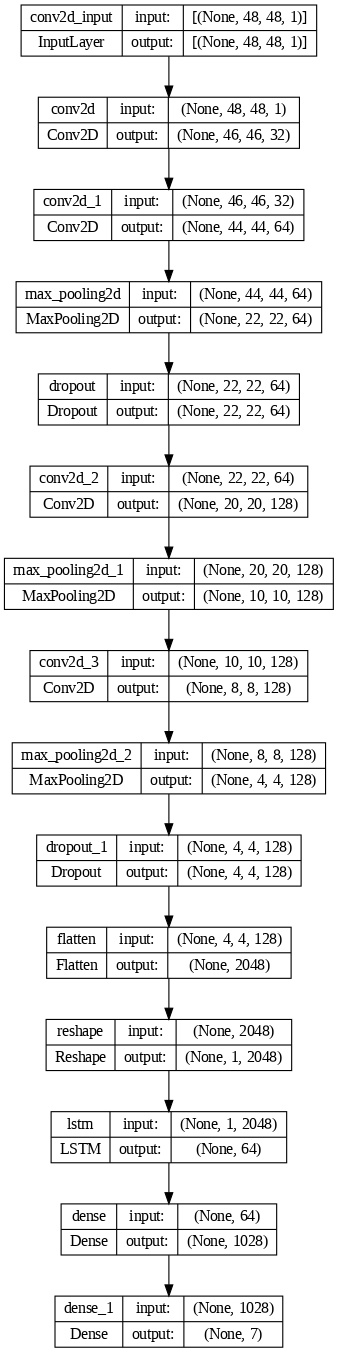

In [37]:
plot_model(model,show_shapes = True, show_layer_names=True, expand_nested=True, dpi=80)

In [41]:
train_datagen_1 = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

# train_datagen_2 = ImageDataGenerator(
#     rotation_range=8,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.08,
#     horizontal_flip=True,
# )

In [38]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.4,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [39]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [44]:
history = model.fit(
    train_datagen_1.flow(X_train, y_train, batch_size =20),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / 20,
    epochs=100,
    # callbacks=callbacks,
)

Epoch 1/100
34/34 [==============================] - 11s 328ms/step - loss: 0.6847 - accuracy: 0.7493 - val_loss: 0.5911 - val_accuracy: 0.7559
Epoch 2/100
34/34 [==============================] - 10s 289ms/step - loss: 0.6418 - accuracy: 0.7653 - val_loss: 0.5515 - val_accuracy: 0.7898
Epoch 3/100
34/34 [==============================] - 11s 319ms/step - loss: 0.6549 - accuracy: 0.7668 - val_loss: 0.5622 - val_accuracy: 0.7864
Epoch 4/100
34/34 [==============================] - 11s 329ms/step - loss: 0.6254 - accuracy: 0.7726 - val_loss: 0.5626 - val_accuracy: 0.7763
Epoch 5/100
34/34 [==============================] - 11s 310ms/step - loss: 0.6416 - accuracy: 0.7536 - val_loss: 0.5336 - val_accuracy: 0.7831
Epoch 6/100
34/34 [==============================] - 13s 369ms/step - loss: 0.6240 - accuracy: 0.7843 - val_loss: 0.5219 - val_accuracy: 0.7898
Epoch 7/100
34/34 [==============================] - 10s 290ms/step - loss: 0.5821 - accuracy: 0.7799 - val_loss: 0.5442 - val_accuracy:

In [50]:
model.save("/content/drive/MyDrive/"+"saved_models/cnn_lstm_7_classes.h5")

In [53]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

# scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
# pyplot.savefig(path+f"confusion_matrix/cnn_lstm_{7}_classes.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

# print(classification_report(ytest_, yhat_test))

10/10 [==============================] - 1s 91ms/step
test accuracy: 91.1864 %




In [54]:
yhat_train = np.argmax(model.predict(X_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

train_accu = np.sum(ytrain_ == yhat_train) / len(ytrain_) * 100
print(f"train accuracy: {round(train_accu, 4)} %")

22/22 [==============================] - 4s 180ms/step
train accuracy: 95.1895 %
